In [5]:
from math import log
import decisionTreePlot as dtPlot

In [ ]:
dataSet = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no']]
labels = ['no surfacing', 'flippers']

In [13]:
def calcShannonEnt(dataSet):
    # 求list的长度，表示计算参与训练的数据量
    numEntries = len(dataSet)
    # 计算分类标签label出现的次数
    labelCounts = {}
    # the the number of unique elements and their occurance
    for featVec in dataSet:
        # 将当前实例的标签存储，即每一行数据的最后一个数据代表的是标签
        currentLabel = featVec[-1]
#         print 'currentLabel-----'+currentLabel
        # 为所有可能的分类创建字典，如果当前的键值不存在，则扩展字典并将当前键值加入字典。每个键值都记录了当前类别出现的次数。
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
        
    # 对于 label 标签的占比，求出 label 标签的香农熵
    shannonEnt = 0.0
    for key in labelCounts:
        # 使用所有类标签的发生频率计算类别出现的概率。
        prob = float(labelCounts[key])/numEntries
        # 计算香农熵，以 2 为底求对数
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [ ]:
calcShannonEnt(dataSet)

In [14]:
def splitDataSet(dataSet, index, value):
    """
    splitDataSet(通过遍历dataSet数据集，求出index对应的colnum列的值为value的行)
    就是依据index列进行分类，如果index列的数据等于 value的时候，就要将 index 划分到我们创建的新的数据集中
    Args:
        dataSet 数据集 待划分的数据集
        index 表示每一行的index列 划分数据集的特征
        value 表示index列对应的value值   需要返回的特征的值。
    Returns:
        index列为value的数据集【该数据集需要排除index列】
    """
    retDataSet = []
    for featVec in dataSet:
        # index列为value的数据集【该数据集需要排除index列】
        # 判断index列的值是否为value
        if featVec[index] == value:
            # chop out index used for splitting
            # [:index]表示前index行，若 index 为2，就是取 featVec 的前 index 行
            reducedFeatVec = featVec[:index]
            reducedFeatVec.extend(featVec[index+1:])
            # [index+1:]表示从跳过 index 的 index+1行，取接下来的数据
            # 收集结果值 index列为value的行【该行需要排除index列】
            retDataSet.append(reducedFeatVec)
    return retDataSet


In [ ]:
splitDataSet(dataSet, 0, 0)

In [ ]:
splitDataSet(dataSet, 0, 1)

In [ ]:
splitDataSet(dataSet, 1, 0)

In [ ]:
splitDataSet(dataSet, 1, 1)

In [15]:
def chooseBestFeatureToSplit(dataSet):
    """
    chooseBestFeatureToSplit(选择最好的特征)
    Args:
        dataSet 数据集
    Returns:
        bestFeature 最优的特征列
    """
    # 求第一行有多少列的 Feature, 最后一列是label列嘛
    numFeatures = len(dataSet[0]) - 1
    # 数据集的原始信息熵
    baseEntropy = calcShannonEnt(dataSet)
    # 最优的信息增益值, 和最优的Featurn编号
    bestInfoGain, bestFeature = 0.0, -1
    # iterate over all the features
    for i in range(numFeatures):
        # create a list of all the examples of this feature
        # 获取对应的feature下的所有数据
        featList = [example[i] for example in dataSet]
        # get a set of unique values
        # 获取剔重后的集合，使用set对list数据进行去重
        uniqueVals = set(featList)
        # 创建一个临时的信息熵
        newEntropy = 0.0
        # 遍历某一列的value集合，计算该列的信息熵
        # 遍历当前特征中的所有唯一属性值，对每个唯一属性值划分一次数据集，计算数据集的新熵值，并对所有唯一特征值得到的熵求和。
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            # 计算概率
            prob = len(subDataSet)/float(len(dataSet))
            # 计算信息熵
            newEntropy += prob * calcShannonEnt(subDataSet)
            # gain[信息增益]: 划分数据集前后的信息变化， 获取信息熵最大的值
            # 信息增益是熵的减少或者是数据无序度的减少。最后，比较所有特征中的信息增益，返回最好特征划分的索引值。
            infoGain = baseEntropy - newEntropy
        print ('infoGain=', infoGain, 'bestFeature=', i, baseEntropy, newEntropy)
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

In [ ]:
chooseBestFeatureToSplit(dataSet)

In [16]:
# 没有特征了，但还不是同一类，分不了了，多数表决的计算节点分类
# 返回最多label
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    return max(classCount)  

In [ ]:
majorityCnt(['yes', 'yes', 'no'])

In [17]:
def createTree(dataSet, labels):
    labels = labels[:]
    classList = [example[-1] for example in dataSet]
    # 如果数据集的最后一列的第一个值出现的次数=整个集合的数量，也就说只有一个类别，就只直接返回结果就行
    # 第一个停止条件：所有的类标签完全相同，则直接返回该类标签。
    # count() 函数是统计括号中的值在list中出现的次数
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    
    # 如果数据集只有1列，那么最初出现label次数最多的一类，作为结果
    # 第二个停止条件：使用完了所有特征，仍然不能将数据集划分成仅包含唯一类别的分组。
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    # 选择最优的列，得到最优列对应的label含义
    bestFeat = chooseBestFeatureToSplit(dataSet) # 0
    # 获取label的名称
    bestFeatLabel = labels[bestFeat] # 'no surfacing'
    # 初始化myTree
    myTree = {bestFeatLabel: {}} # {'no surfacing': {} }
    # 注：labels列表是可变对象，在PYTHON函数中作为参数时传址引用，能够被全局修改
    # 所以这行代码导致函数外的同名变量被删除了元素，造成例句无法执行，提示'no surfacing' is not in list
    del(labels[bestFeat]) 
    # 取出最优列，然后它的branch做分类
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        # 求出剩余的标签label
        subLabels = labels[:]
        # 遍历当前选择特征包含的所有属性值，在每个数据集划分上递归调用函数createTree()
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
        print ('myTree', value, myTree)
    return myTree

In [18]:
myTree = createTree(dataSet, labels)

NameError: name 'dataSet' is not defined

```
[[1, 'no'], [1, 'no']]
[[1, 'yes'], [1, 'yes'], [0, 'no']]
labels = ['flippers']

{
  'no surfacing': {
    0: 'no',
    1: {
      'flippers': {
        0: 'no',
        1: 'yes'
      }
    }
  }
}
```

In [ ]:
def classify(inputTree, featLabels, testVec):
    """
    classify(给输入的节点，进行分类)
    Args:
        inputTree  决策树模型
        featLabels Feature标签对应的名称
        testVec    测试输入的数据
    Returns:
        classLabel 分类的结果值，需要映射label才能知道名称
    """
    # 获取tree的根节点对于的key值
    firstStr = list(inputTree.keys())[0]
    # 通过key得到根节点对应的value
    secondDict = inputTree[firstStr]
    # 判断根节点名称获取根节点在label中的先后顺序，这样就知道输入的testVec怎么开始对照树来做分类
    featIndex = featLabels.index(firstStr)
    # 测试数据，找到根节点对应的label位置，也就知道从输入的数据的第几位来开始分类
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    print ('+++', firstStr, 'xxx', secondDict, '---', key, '>>>', valueOfFeat)
    
    # 判断分枝是否结束: 判断valueOfFeat是否是dict类型
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:
        classLabel = valueOfFeat
    return classLabel

In [ ]:
classify(myTree, labels, [1, 0])

In [ ]:
labels

In [ ]:
list(myTree.keys())[0]

In [ ]:
myTree

### 存储决策树
- pickle 默认以是二进制方式操作
- 读写方法，加个b

In [2]:
# 存储
def storeTree(inputTree, fileName):
    import pickle
    fw = open(fileName, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()

# 读取
def grabTree(fileName):
    import pickle
    fr = open(fileName, 'rb')
    return pickle.load(fr)

In [ ]:
storeTree(myTree, '3.DecisionTree/storeTree.data')

In [8]:
myTree = grabTree('3.DecisionTree/storeTree.data')

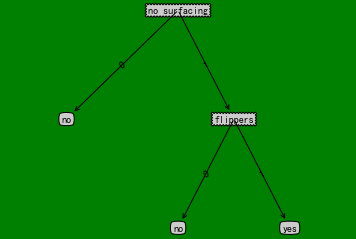

In [9]:
# 画图可视化展现
dtPlot.createPlot(myTree)

# 预测隐形眼镜的测试代码

In [28]:
fr = open('3.DecisionTree/lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

In [29]:
print(lenses)

[['young', 'myope', 'no', 'reduced', 'no lenses'], ['young', 'myope', 'no', 'normal', 'soft'], ['young', 'myope', 'yes', 'reduced', 'no lenses'], ['young', 'myope', 'yes', 'normal', 'hard'], ['young', 'hyper', 'no', 'reduced', 'no lenses'], ['young', 'hyper', 'no', 'normal', 'soft'], ['young', 'hyper', 'yes', 'reduced', 'no lenses'], ['young', 'hyper', 'yes', 'normal', 'hard'], ['pre', 'myope', 'no', 'reduced', 'no lenses'], ['pre', 'myope', 'no', 'normal', 'soft'], ['pre', 'myope', 'yes', 'reduced', 'no lenses'], ['pre', 'myope', 'yes', 'normal', 'hard'], ['pre', 'hyper', 'no', 'reduced', 'no lenses'], ['pre', 'hyper', 'no', 'normal', 'soft'], ['pre', 'hyper', 'yes', 'reduced', 'no lenses'], ['pre', 'hyper', 'yes', 'normal', 'no lenses'], ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'], ['presbyopic', 'myope', 'no', 'normal', 'no lenses'], ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'], ['presbyopic', 'myope', 'yes', 'normal', 'hard'], ['presbyopic', 'hyper', 'no', 'redu

In [34]:
lensesTree = createTree(lenses, lensesLabels)

infoGain= 0.03939650364612124 bestFeature= 0 1.3260875253642983 1.286691021718177
infoGain= 0.039510835423565815 bestFeature= 1 1.3260875253642983 1.2865766899407325
infoGain= 0.37700523001147723 bestFeature= 2 1.3260875253642983 0.9490822953528211
infoGain= 0.5487949406953986 bestFeature= 3 1.3260875253642983 0.7772925846688997
infoGain= 0.22125183600446618 bestFeature= 0 1.5545851693377994 1.3333333333333333
infoGain= 0.09543725231055489 bestFeature= 1 1.5545851693377994 1.4591479170272446
infoGain= 0.7704260414863776 bestFeature= 2 1.5545851693377994 0.7841591278514218
infoGain= 0.3166890883150208 bestFeature= 0 0.6500224216483541 0.3333333333333333
infoGain= 0.19087450462110933 bestFeature= 1 0.6500224216483541 0.4591479170272448
infoGain= 1.0 bestFeature= 0 1.0 0.0
myTree myope {'prescript': {'myope': 'no lenses'}}
myTree hyper {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}
myTree presbyopic {'age': {'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}}
my

In [36]:
# storeTree(lensesTree, '3.DecisionTree/lensesTree.data')
lensesTree = grabTree('3.DecisionTree/lensesTree.data')

In [37]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

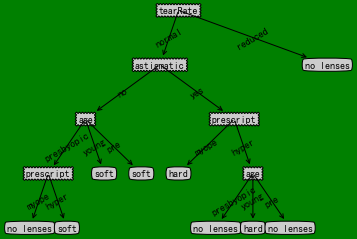

In [38]:
dtPlot.createPlot(lensesTree)

```
{
  'tearRate': {
    'normal': {
      'astigmatic': {
        'no': {
          'age': {
            'pre': 'soft',
            'presbyopic': {
              'prescript': {
                'hyper': 'soft',
                'myope': 'no lenses'
              }
            },
            'young': 'soft'
          }
        },
        'yes': {
          'prescript': {
            'hyper': {
              'age': {
                'pre': 'no lenses',
                'presbyopic': 'no lenses',
                'young': 'hard'
              }
            },
            'myope': 'hard'
          }
        }
      }
    },
    'reduced': 'no lenses'
  }
}
```